RNN -  넷플릭스 주가 예측
  - 순서가 없는 데이터
  - 모델의 입력으로 행렬 하나를 넣었다
  - 데이터의 순서로부터 특징을 추출하는 방법
  - 데이터는 순서대로 입력
  - 모델은 과거 정보와 현재정보를 둘다 가지고 있어야 한다
  - 모델이 출력한 과거의 정보를 다시 입력으로 넣어줘야 함
  - Recursive : RNN(순환신경망)

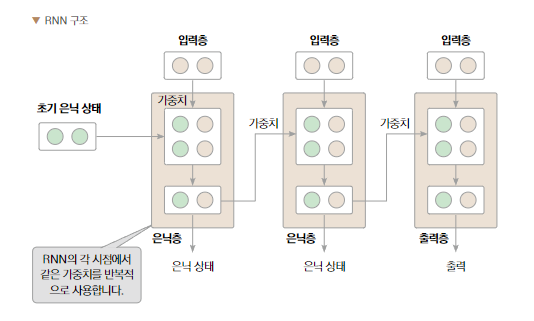

In [ ]:
!unzip /content/netflix-stock-prediction.zip

In [78]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


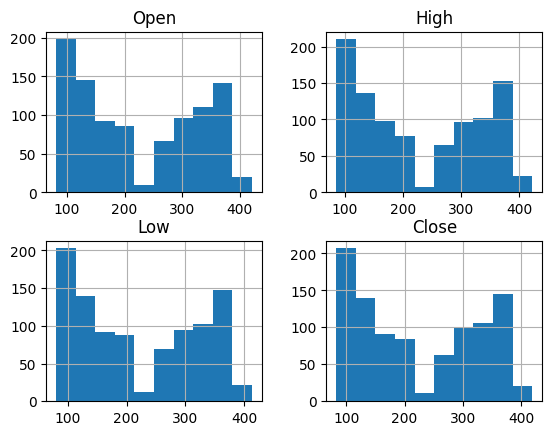

In [79]:
import matplotlib.pyplot as plt
data = df[['Open',	'High',	'Low','Close']]
data.hist()
plt.show()

In [80]:
import numpy as np
# 값이 넓게 분포되어 있어서 출력값의 범위가 커지면 오차의 범위가 커진다.
# 값의 범위를 0~1사이로 정규화
X = data.iloc[:, :-1]
y = data.iloc[:,-1]


X_scaled = X / np.max(X)
y_scaled = y / np.max(y)

In [81]:
X_scaled.shape

(967, 3)

In [82]:
# 데이터 셋 정의
import numpy as np
from torch.utils.data.dataset import Dataset

class Netflix(Dataset):
  def __init__(self):
    self.csv = pd.read_csv('/content/train.csv')
    # 정규화
    self.csv = self.csv[['Open',	'High',	'Low','Close']]

    self.data = self.csv.iloc[:,:-1]
    self.label = self.data.iloc[:,-1]

    self.data = (self.data / np.max(self.data) ).to_numpy()
    self.label = (self.label / np.max(self.label)).to_numpy()

  def __len__(self):  # 사용가능한 배치수
    return len(self.data) - 30

  def __getitem__(self, index):
    data = self.data[index : index + 30]
    label = self.label[index + 30]
    return data, label

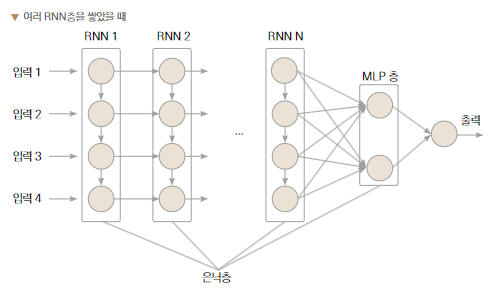

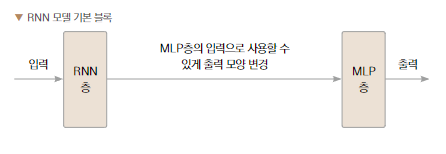

In [83]:
# RNN 클래스
import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

In [84]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    # RNN층 정의
    self.rnn = nn.RNN(input_size = 3, hidden_size=8,num_layers=5,batch_first=True)  # 30일치로 묶었고.. 배치크기  [32, 30, 8]

    # 주가를 예측하는 MLP층을 정의
    self.fc1 = nn.Linear(in_features=30*8, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()

  # 초기데이터는 초기 은닉상태, 입력데이터
  def forward(self,x,ho):
    x, hn = self.rnn(x, ho)  # x 마지막rnn층의 은닉상태, hn 모든 rnn층의 은닉상태를 반환
    x = torch.reshape(x, (x.shape[0], -1))

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    x = torch.flatten(x)
    return x

In [85]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Netflix()
loader = DataLoader(dataset, batch_size=32)
model = RNN().to(device)
optim = Adam(model.parameters(), lr = 1e-4)

In [86]:
# 학습루프
from tqdm import tqdm
for epoch in range(200):
  iterator = tqdm(loader)
  for data, label in iterator:
    optim.zero_grad()
    # 초기 은닉상태  모든 요소가 0인 덴서
    h0 = torch.zeros(5,data.shape[0], 8).to(device)  # (5, 32, 8)  은닉층개수, 배치크기, 출력의차원
    pred = model(data.type(torch.FloatTensor).to(device), h0)     # 예측값
    loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()

    iterator.set_description(f'epoch:{epoch} loss:{loss.item()}')

torch.save(model.state_dict(), './rnn.pth')


epoch:199 loss:0.00034948575193993747: 100%|██████████| 30/30 [00:00<00:00, 35.37it/s]


모델 성능평가

In [87]:
import matplotlib.pyplot as plt
loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
  model.load_state_dict(torch.load('rnn.pth', map_location=device))
  for data, label in loader:
    h0 = torch.zeros(5, data.shape[0], 8).to(device)

    pred = model(data.type(torch.FloatTensor).to(device), h0)
    preds.append(pred.item())

    loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))

    total_loss += loss/len(loader)

In [88]:
total_loss.item()

0.0015494032995775342

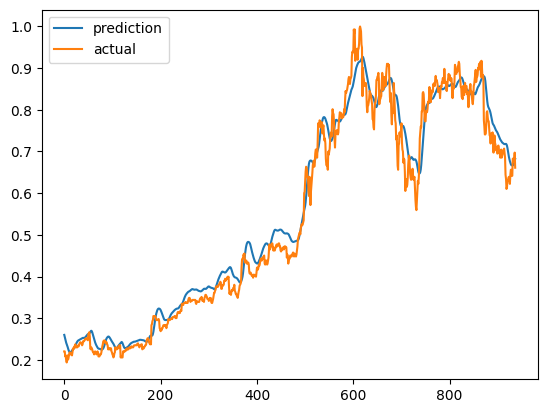

In [89]:
plt.plot(preds, label = "prediction")
plt.plot(dataset.label[30:], label='actual')
plt.legend()
plt.show()